In [1]:
from crpropa import *
from crpropa import Module
from Monopole import Monopole

In [2]:
from numpy import sqrt, log
#From MacColl, L. A. (1938). The Motion of a Relativistic Particle in a Uniform Field of Force. The American Mathematical Monthly, 45(10), 669–676. https://doi.org/10.2307/2302436
#Assumes field in +y direction
def analytical_position(max_time, number_steps, g, B, m, t, energy, direction):
    #helper values
    p = sqrt((energy + m*c_squared)**2 - (m*c_squared)**2)/c_light
    gamma = -1 * g * B / m
    ux = p * direction.getUnitVector().x / m
    uy = p * direction.getUnitVector().y / m
    A = sqrt(c_squared + ux**2 + uy**2)
    
    #Calculate
    x = c_light * ux / gamma * log((gamma * t - uy + sqrt((gamma * t - uy)**2 + c_squared + ux**2))/(A - uy))
    y = A * c_light / gamma - c_light / gamma * sqrt((gamma * t - uy)**2 + c_squared + ux**2)
    return x / pc, y / pc

In [3]:
class MyTrajectoryOutput(Module):
    def __init__(self, fname):
        Module.__init__(self)
        #self.fout = open(fname, 'w')
        #self.fout.write('%i\t%.3f\t%.3f\t%.3f\n'%(1, 0, 0, 0))
    def process(self, c):
        i = 1
        c = Monopole.MCandidate.convertToMCandidate(c)
        v = c.Mcurrent.getVelocity()
        x = v.x
        y = v.y
        z = v.z
        #self.fout.write('%i\t%.3f\t%.3f\t%.3f\n'%(i, x, y, z))
    def close(self):
        pass
        #self.fout.close()

In [22]:
import time as Time

B = 10*nG
direction_B = Vector3d(0, 1, 0)

m = 100*gigaelectronvolt/c_squared 
g = 1*Monopole.gD

const_mag_vec = direction_B * B
reg_field = UniformMagneticField(const_mag_vec)


### Running the simulation with either CK or BP
def run_simulation(module, max_time, number_steps, g, m, energy, direction):
    position = Vector3d(0, 0, 0)

    c = Monopole.MCandidate(4110000, energy, position, direction.getUnitVector(), m, g)
    print(c.Mcurrent.getDescription())
    
    steplength = max_time/number_steps * c_light
    sim = ModuleList()
    if module == 'CK':
        sim.add(Monopole.MonopolePropagationCK(reg_field,1e-4,steplength, steplength))
        trajectory_output = TextOutput('trajectory_CK.txt', Output.Trajectory3D)
    elif module == 'BP':
        sim.add(Monopole.MonopolePropagationBP(reg_field, steplength))
        trajectory_output = TextOutput('trajectory_BP.txt', Output.Trajectory3D)
    else:
        print('no module found. Use either BP or CK.')
        return

    debug = MyTrajectoryOutput('.txt')
    # we only want to simulate a certain trajectory length
    sim.add(MaximumTrajectoryLength(max_time*c_light))
    # the output information will be saved in pc instead of the default which is Mpc
    trajectory_output.setLengthScale(pc)
    # each particle position will be saved in the above specified text field.
    sim.add(trajectory_output)
    sim.add(debug)
    # compare the simulation time of both propagation methods
    t0 = Time.time()
    # run the simulation
    sim.run(c, True)
    t1 = Time.time()
    trajectory_output.close()
    debug.close() # flush particles to ouput file
    print('Simulation time with module '+ str(module)+' is '+str(t1-t0)+'s.')
    Time.sleep(0.1)


In [23]:
import matplotlib.pyplot as plt
import numpy as np

def plot_subplots_para(ax1, ax2, data, x_ana, y_ana, t, module, color):
    #numerical
    ax1.scatter(data.X[::100] ,data.Y[::100], color = color, label=module, zorder=5, s=10)
    ax1.legend(markerscale=5)
    
    #analytical
    ax1.plot(x_ana,y_ana,color = 'k', label='analytical', ls='-')
    ax1.legend()
    
    # compare with analytical solution
    comp = sqrt((data.X-np.array(x_ana))**2 + (data.Y-np.array(y_ana))**2)
    ax2.scatter(t, comp,s=1, color = color, label=module)
    ax2.legend(markerscale=5)
    
def plot_figure_para(max_time, number_steps, g, B, m, energy, direction):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(12,12))

    # calculate the time stamps similar to that used in the numerical simulation
    data1 = load_trajectory('trajectory_BP.txt')
    data2 = load_trajectory('trajectory_CK.txt')
    
    t = np.linspace(0, max_time, len(data2))
    x_ana, y_ana = analytical_position(max_time, number_steps, g, B, m, t, energy, direction)

    plot_subplots_para(ax1, ax2, data1, x_ana, y_ana, t, 'BP', 'brown')
    plot_subplots_para(ax3, ax4, data2, x_ana, y_ana, t, 'CK', 'dodgerblue')
    
    ax1.set_xlabel('$x$ [pc]')
    ax1.set_ylabel('$y$ [pc]')
    ax1.set_title('Trajectory', fontsize=18)
    
    ax2.set_xlabel('t [s]')
    ax2.set_ylabel('Position error [pc]')
    ax2.set_title('Position error vs. time', fontsize=18)
    
    ax3.set_xlabel('$x$ [pc]')
    ax3.set_ylabel('$y$ [pc]')
    ax4.set_xlabel('t [s]')
    ax4.set_ylabel('Position error [pc]')
    
    fig.tight_layout()
    plt.show()

In [24]:
import pandas as pd

def load_trajectory(text):
    data = pd.read_csv(text,
                 names=['D','ID','E','X','Y','Z','Px','Py','Pz'], delimiter='\t', comment='#',
                 usecols=["D", "X", "Y", "Z","Px","Py","Pz"])
    top = pd.DataFrame([{"D": 0, "X":0, "Y":0, "Z":0, "Py":0, "Pz":0}])
    data = pd.concat([top, data]).reset_index(drop = True)
    data.drop(data.tail(1).index,inplace=True) # drop last n rows
    return data

#def load_velocity(text):
#    I, X,Y,Z = np.genfromtxt(text, unpack=True, skip_footer=1)
#    return Z

Particle 4110000, E = 10 EeV, x = 0 0 0 Mpc, p = 0.0995037 -0.995037 0 (direction), q = 0 C, m = 1 GeV/c^2, gD = 1 gD
Simulation time with module CK is 0.13385701179504395s.
Particle 4110000, E = 10 EeV, x = 0 0 0 Mpc, p = 0.0995037 -0.995037 0 (direction), q = 0 C, m = 1 GeV/c^2, gD = 1 gD
Simulation time with module BP is 0.10101699829101562s.


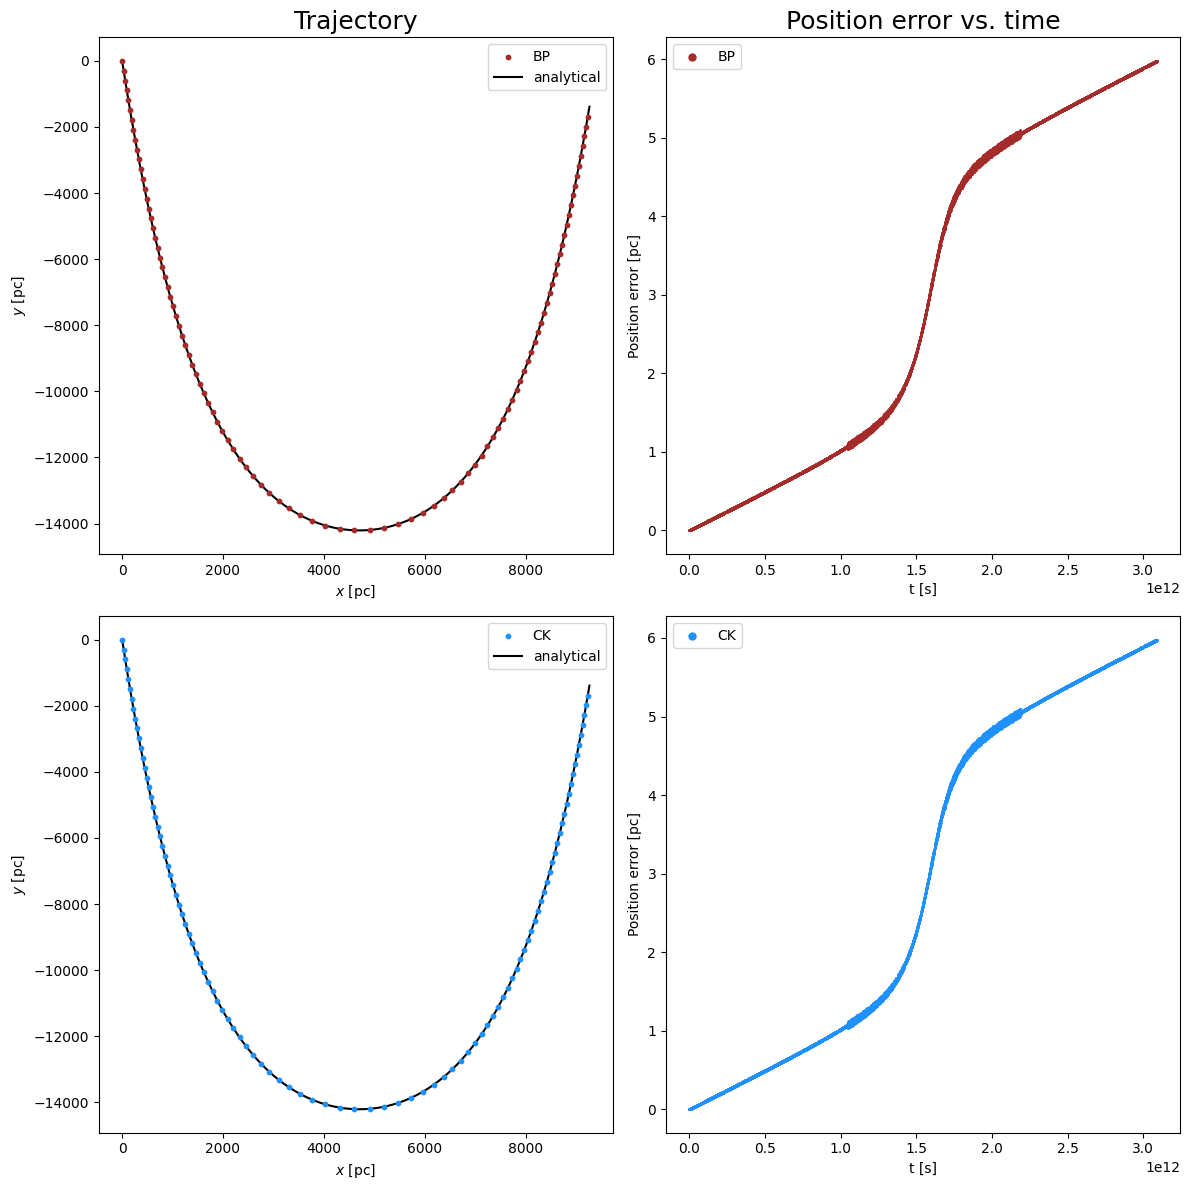

In [25]:
max_trajectory = 30 * kpc
max_time = max_trajectory / c_light
number_steps = 10000
energy = 10 * EeV #KE
direction = Vector3d(0.1, -1, 0).getUnitVector()
run_simulation('CK', max_time, number_steps, g, m, energy, direction)
run_simulation('BP', max_time, number_steps, g, m, energy, direction)
plot_figure_para(max_time, number_steps, g, B, m, energy, direction)